### 1. 데이터셋 내려받기

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    with_info=True,
    as_supervised=True,
)

### 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
- 이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches 준비

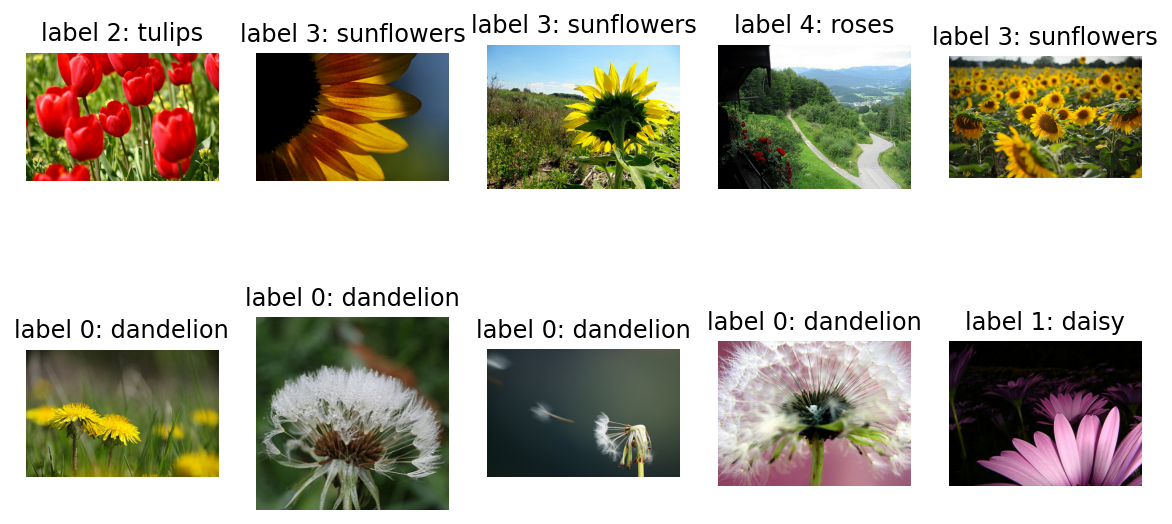

In [2]:
# 데이터 확인
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [3]:
# 이미지 크기 포맷
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [4]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

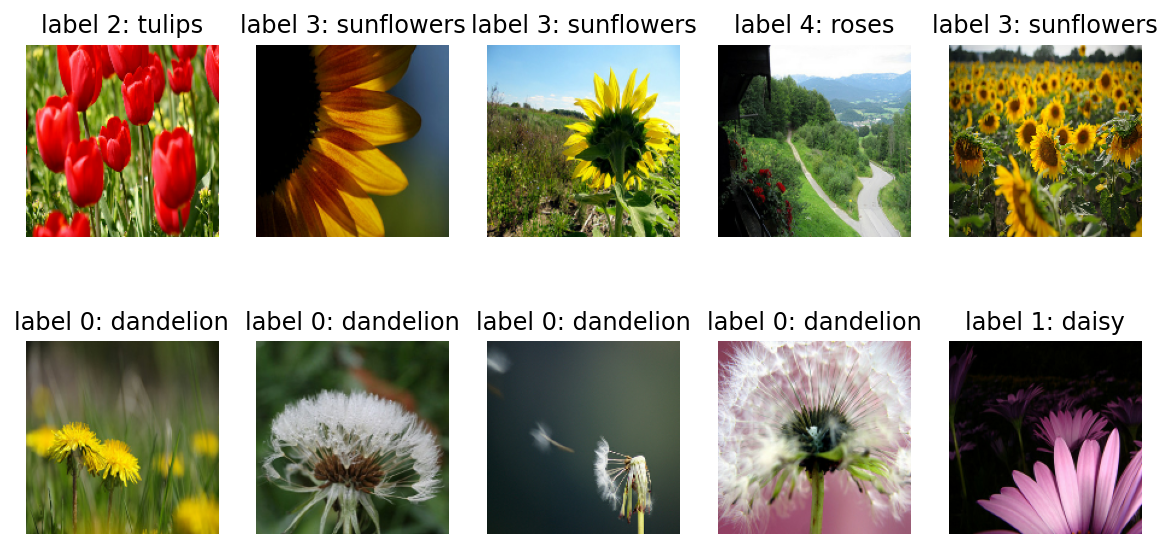

In [6]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)): # raw_train을 train으로 변경
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2  # matplotlib으로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야 하므로, -1~1 사이의 픽셀값을 1을 더한 후 2로 나눠서 0~1 사이의 값으로 변환
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')
    
    
# 결과: 이미지 크기 균일(160, 160, 3)

### 3. 모델 설계하기
- 데이터가 3,670개로 적기 때문에 base_model 이용

#### 3-1. 모델 구조 설계

In [7]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [8]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax') # 클래스 5개
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

#### 3-2. 초기 모델

In [9]:
base_learning_rate = 0.0001   # 학습률(learning_rate) 파라미터 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), # 모델 컴파일
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [10]:
# 학습시킬 데이터 준비
BATCH_SIZE = 32  # 한 스텝에 학습시킬 데이터 개수
SHUFFLE_BUFFER_SIZE = 1000  # 학습 데이터 적절히 섞어주는 지표

In [11]:
# BATCH_SIZE에 따라 32개의 데이터를 랜덤 지정
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE) # 모델이 끊임없이 학습할 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
# 하나의 batch 속 데이터 확인
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [13]:
# 모델의 예측 결과 확인
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[0.19318421, 0.25342014, 0.20069842, 0.19923578, 0.15346143],
       [0.19870825, 0.205486  , 0.2242007 , 0.18901394, 0.18259116],
       [0.20020413, 0.23784316, 0.18787217, 0.18724589, 0.18683463],
       [0.21376868, 0.1981335 , 0.20224436, 0.20591383, 0.1799396 ],
       [0.19641024, 0.20550154, 0.20283735, 0.20049872, 0.19475219],
       [0.19990118, 0.2202821 , 0.21926793, 0.21492955, 0.14561926],
       [0.21235193, 0.22889505, 0.19349042, 0.19231291, 0.1729497 ],
       [0.23207143, 0.22574268, 0.18705611, 0.18315983, 0.17196997],
       [0.20587577, 0.26017725, 0.17824721, 0.1984002 , 0.1572996 ],
       [0.20085824, 0.22944145, 0.20124061, 0.18418425, 0.18427548],
       [0.22289446, 0.22391081, 0.19806695, 0.18259685, 0.17253093],
       [0.20252234, 0.24496093, 0.19156088, 0.18401101, 0.17694485],
       [0.2142549 , 0.23895057, 0.17466971, 0.21135381, 0.16077092],
       [0.20819435, 0.22498527, 0.22120519, 0.18108043, 0.16453479],
       [0.21186939, 0.23934919, 0.

#### 3-3. 사전학습모델 VGG16

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                         include_top=False, 
                                         weights='imagenet')
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
base_model.trainable = False

model = tf.keras.Sequential([
  base_model, 
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


### 4. 데이터 학습시키기

In [15]:
base_learning_rate = 0.0003   # 학습률(learning_rate) 파라미터 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), # 모델 컴파일
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [42]:
EPOCHS = 7

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/7
92/92 [==============================] - 7s 75ms/step - loss: 0.4250 - accuracy: 0.8614 - val_loss: 0.4958 - val_accuracy: 0.8174
Epoch 2/7
92/92 [==============================] - 7s 74ms/step - loss: 0.4066 - accuracy: 0.8675 - val_loss: 0.4864 - val_accuracy: 0.8338
Epoch 3/7
92/92 [==============================] - 7s 75ms/step - loss: 0.3886 - accuracy: 0.8672 - val_loss: 0.4787 - val_accuracy: 0.8447
Epoch 4/7
92/92 [==============================] - 7s 74ms/step - loss: 0.3723 - accuracy: 0.8733 - val_loss: 0.4845 - val_accuracy: 0.8338
Epoch 5/7
92/92 [==============================] - 7s 74ms/step - loss: 0.3578 - accuracy: 0.8818 - val_loss: 0.4864 - val_accuracy: 0.8174
Epoch 6/7
92/92 [==============================] - 7s 75ms/step - loss: 0.3481 - accuracy: 0.8842 - val_loss: 0.4850 - val_accuracy: 0.8365
Epoch 7/7
92/92 [==============================] - 7s 76ms/step - loss: 0.3331 - accuracy: 0.8859 - val_loss: 0.4635 - val_accuracy: 0.8229


### 5. 모델 성능 평가

#### 5-1. 학습 과정 그래프

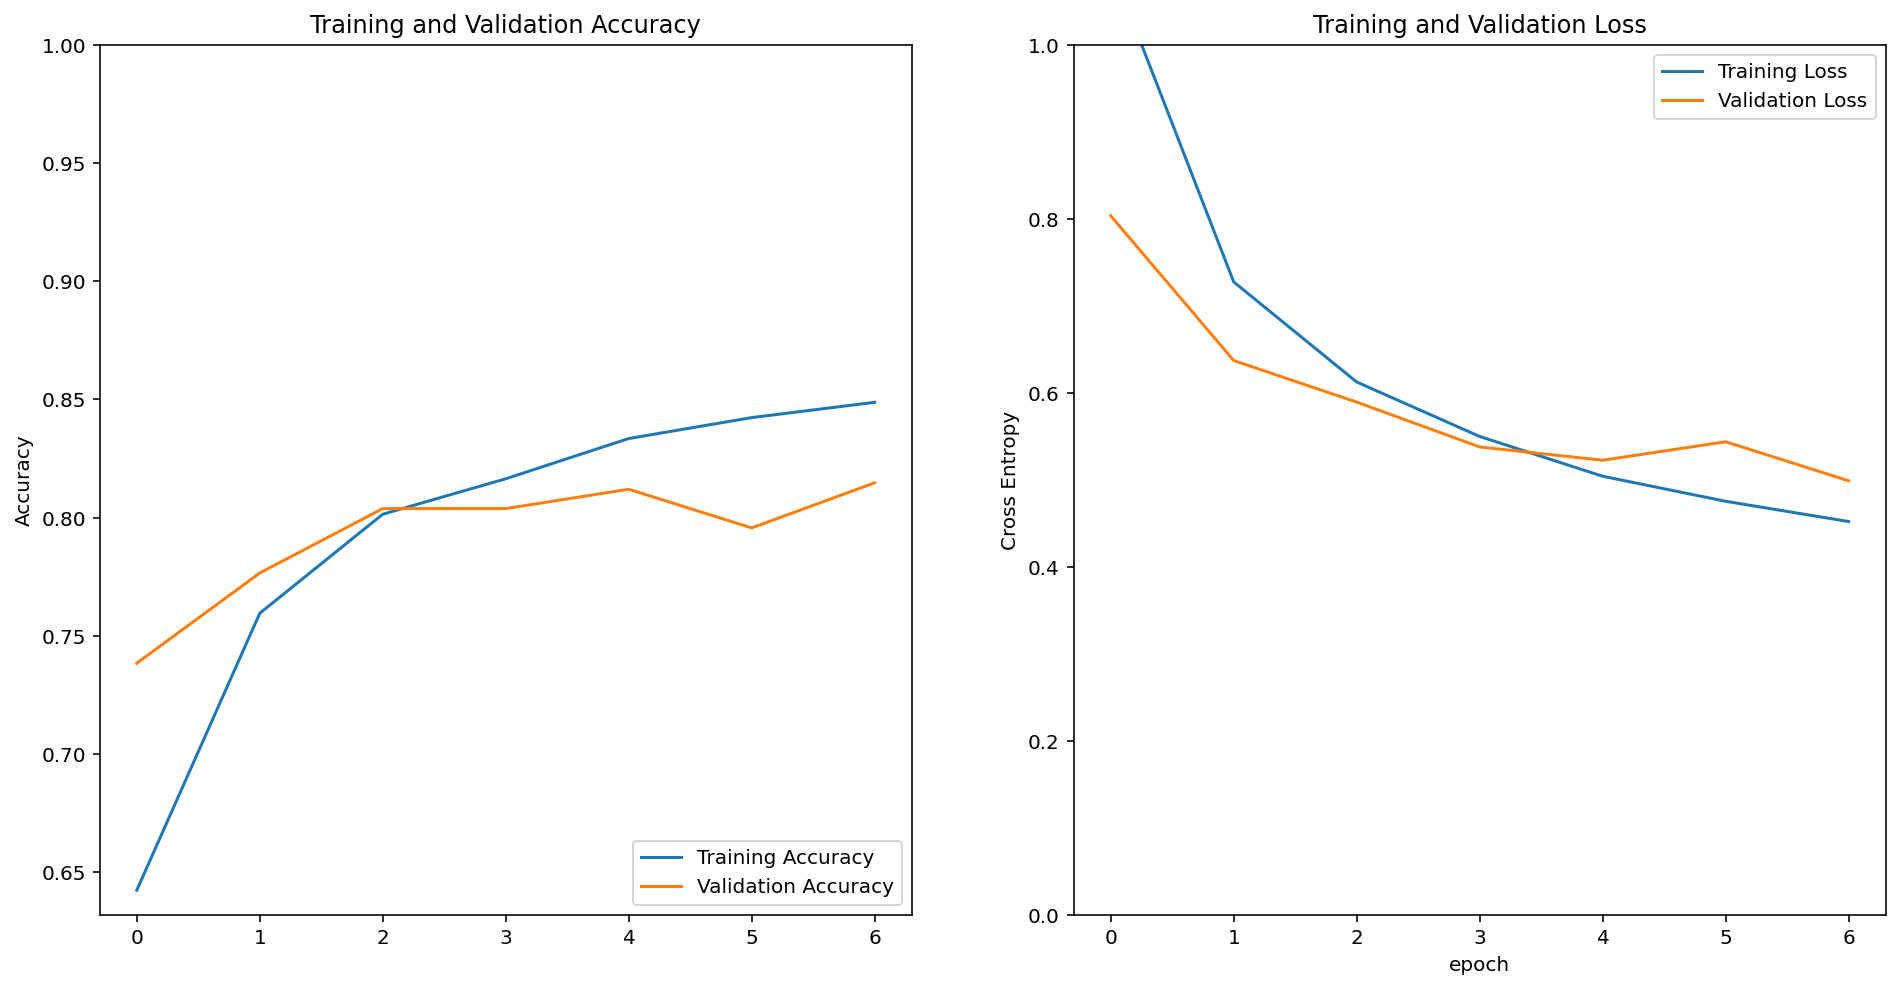

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### 5-2. 예측 결과

In [43]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.21613864e-03, 1.70474462e-02, 8.50965619e-01, 6.98011275e-03,
        1.22790709e-01],
       [9.99845624e-01, 1.42662480e-04, 1.56609005e-07, 1.62268338e-06,
        9.92925470e-06],
       [4.93716180e-01, 2.47722343e-01, 1.45910103e-02, 2.20756188e-01,
        2.32143011e-02],
       [1.56103299e-04, 1.91375066e-03, 5.65805674e-01, 9.06910922e-04,
        4.31217551e-01],
       [5.03965080e-01, 4.64412093e-01, 6.04295079e-03, 1.05153276e-02,
        1.50645841e-02],
       [9.34925735e-01, 4.29262146e-02, 1.51389069e-03, 2.00710110e-02,
        5.63218491e-04],
       [1.43790012e-03, 2.68583256e-03, 9.33729291e-01, 3.96531969e-02,
        2.24936865e-02],
       [1.46488175e-01, 8.24564040e-01, 1.07178297e-04, 2.81776357e-02,
        6.63052837e-04],
       [5.94150915e-04, 1.67497696e-04, 7.02780066e-03, 9.59353805e-01,
        3.28567214e-02],
       [9.99613822e-01, 3.76259821e-04, 1.97875067e-07, 8.66432219e-06,
        1.09018697e-06],
       [9.52301085e-01, 4.3177

#### 5-3. prediction값 라벨로 변환

In [44]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

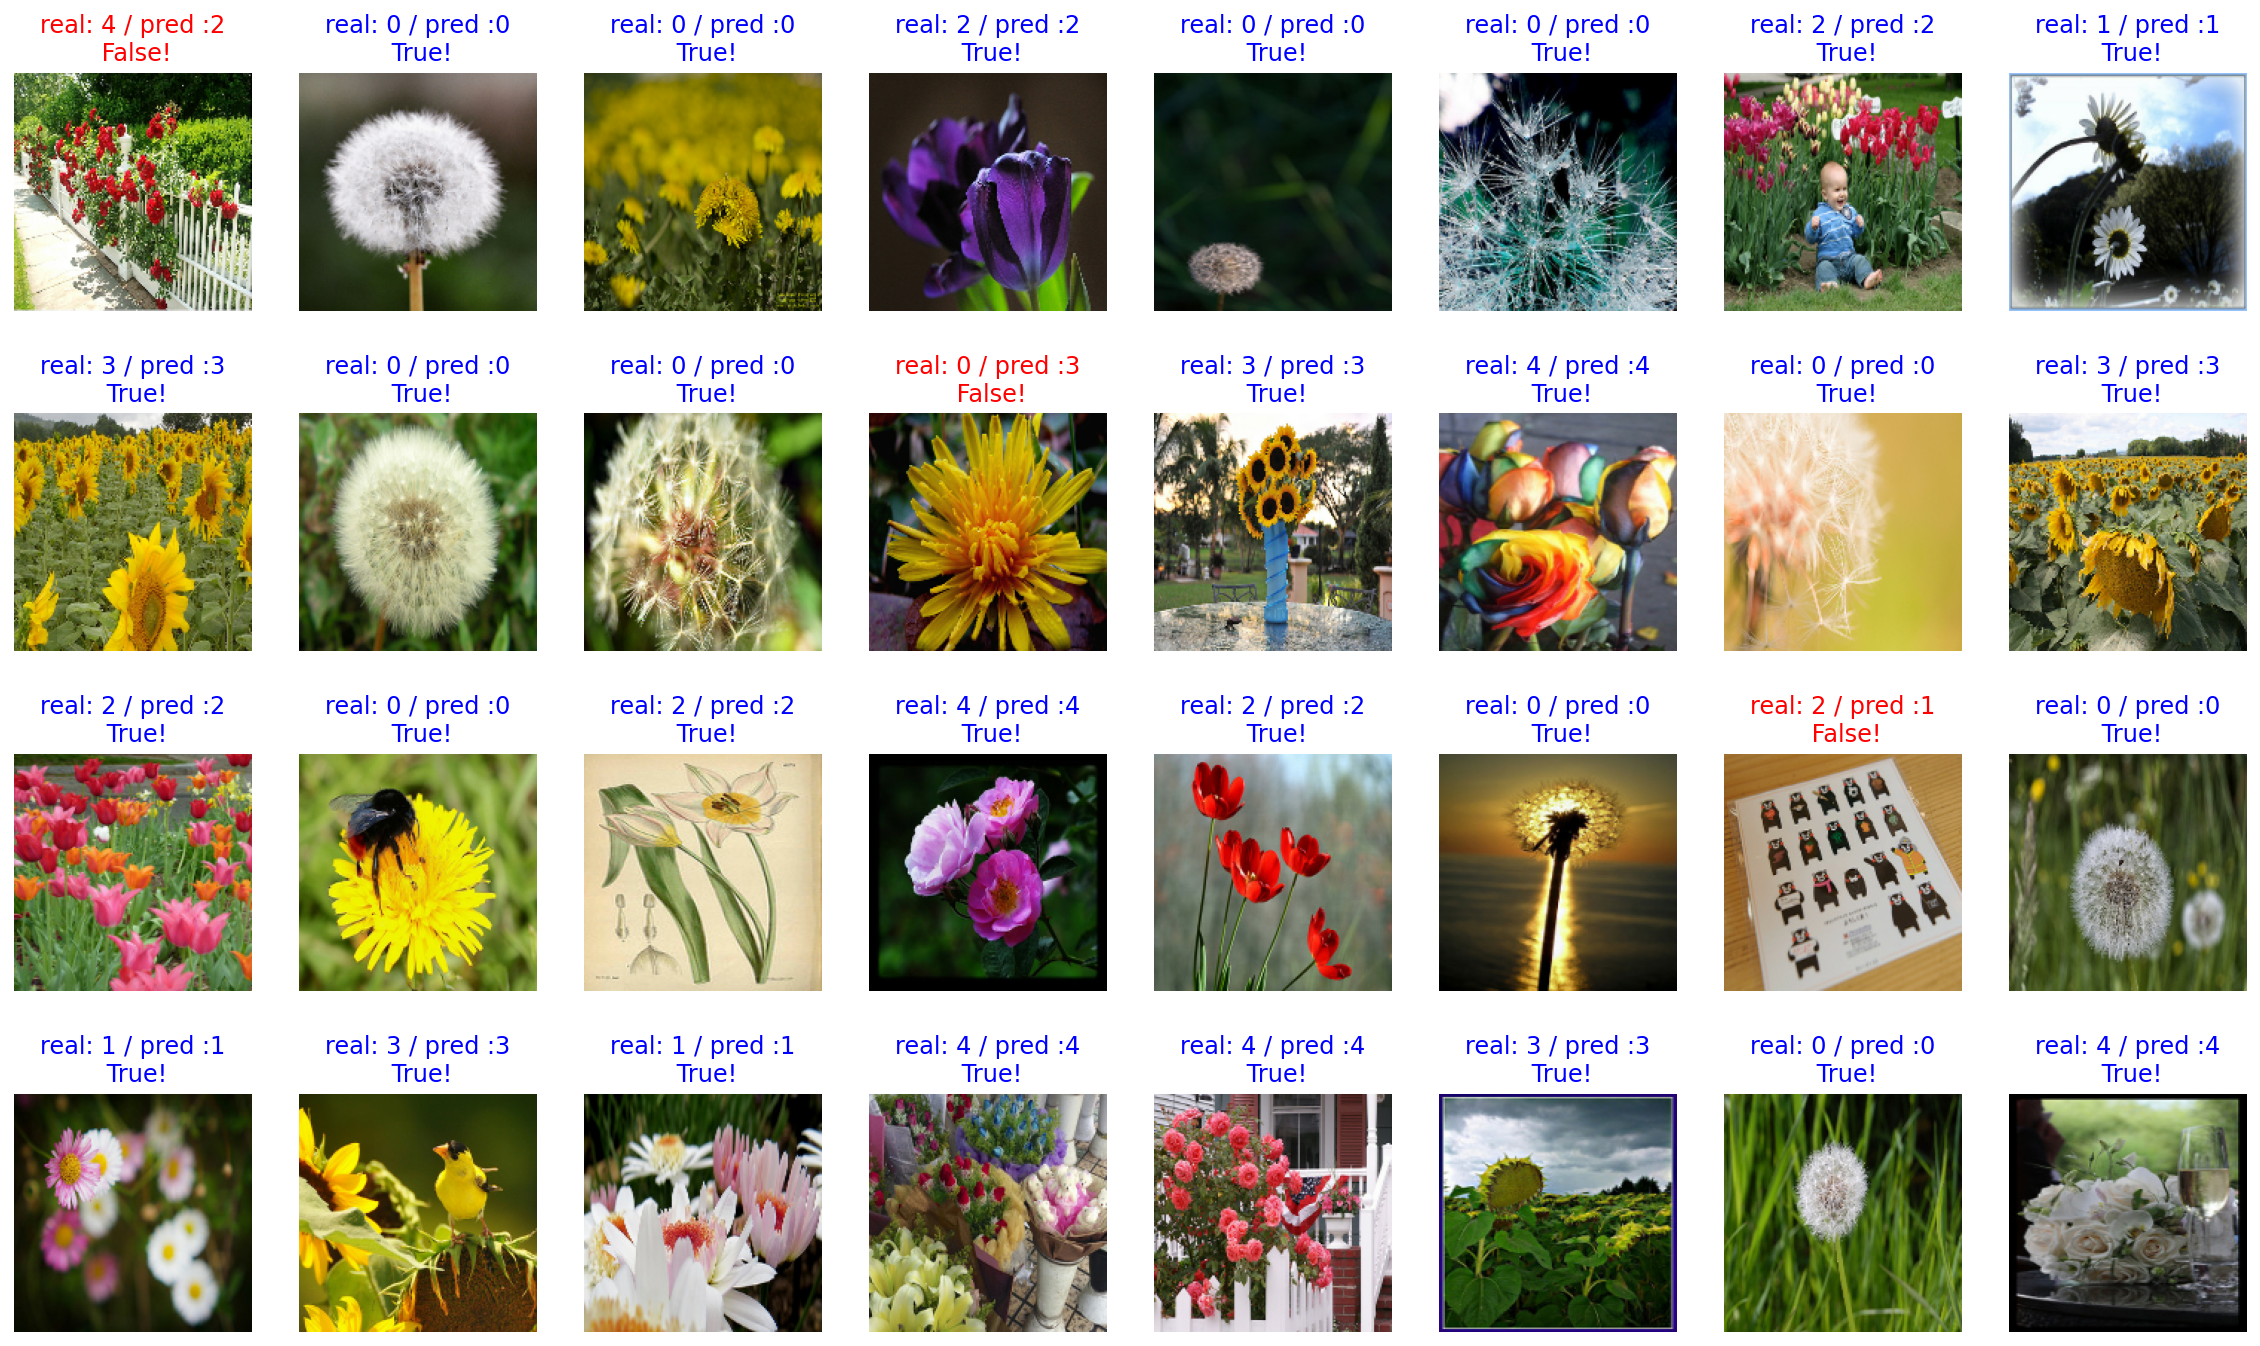

In [45]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

#### 5-4. 정확도 확인

In [46]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(f"accuracy: {count / 32 * 100}")

accuracy: 90.625


### 6. 모델 활용

In [47]:
import os

checkpoint_dir = os.getenv("HOME") + "/workplace/aiffel/Exploration/04. 이미지 분류/flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [48]:
img_dir_path = os.getenv("HOME") + "/workplace/aiffel/Exploration/04. 이미지 분류/flowers/images"
os.path.exists(img_dir_path)

True

In [69]:
# 예측 함수
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    rose_percentage = round(prediction[4] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulip_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    dandelion_percentage = round(prediction[0] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulip_percentage}% tulip, {sunflower_percentage}% sunflower, {rose_percentage}% rose.")

#### Test1. 정확한 튤립 사진: 튤립 100% 달성

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = 160
tulip_image_path = os.path.join(img_dir_path, 'my_tulip.jpeg')

tulip_image = load_img(tulip_image_path, target_size=(IMG_SIZE, IMG_SIZE))

In [51]:
# 이미지를 배열 자료형으로 변환
tulip_image = img_to_array(tulip_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
tulip_image.shape

(1, 160, 160, 3)

In [52]:
# 모델에 넣어 예측: 튤립은 라벨 2 [[0., 0., 1., 0., 0.]]
prediction = model.predict(tulip_image)
prediction

array([[0., 0., 1., 0., 0.]], dtype=float32)

This image seems 0.0% dandelion, 0.0% daisy, 100.0% tulip, 0.0% sunflower, 0.0% rose.


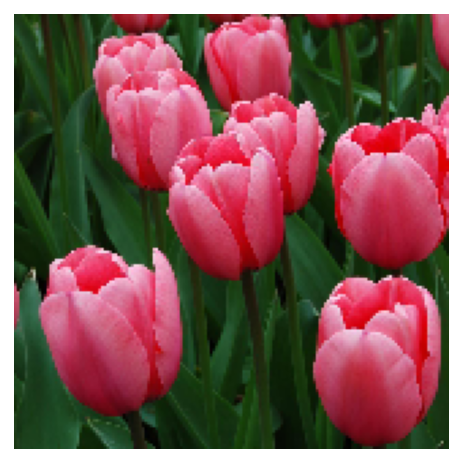

In [70]:
filename = 'my_tulip.jpeg'

show_and_predict_image(img_dir_path, filename)

#### Test2. 어둡고 주변 색과 비슷한 해바라기 사진: 94% 확률로 해바라기 분류

In [54]:
sunflower_image_path = os.path.join(img_dir_path, 'my_sunflower.jpeg')
sunflower_image = load_img(sunflower_image_path, target_size=(IMG_SIZE, IMG_SIZE))

In [55]:
# 이미지를 배열 자료형으로 변환: 해바라기 라벨 3 
sunflower_image = img_to_array(sunflower_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
sunflower_image.shape

(1, 160, 160, 3)

In [56]:
prediction = model.predict(sunflower_image)
prediction

array([[0.0000000e+00, 6.0615782e-02, 2.0862722e-36, 9.3938422e-01,
        0.0000000e+00]], dtype=float32)

This image seems 0.0% dandelion, 6.0% daisy, 0.0% tulip, 94.0% sunflower, 0.0% rose.


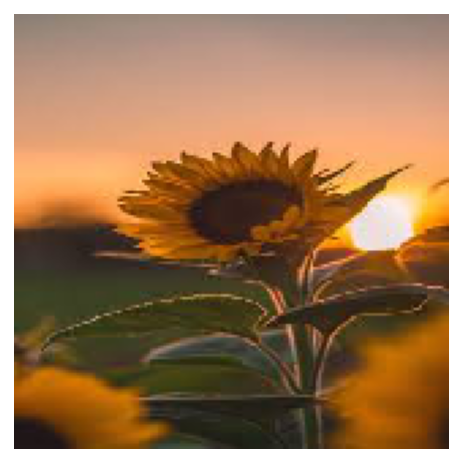

In [71]:
filename = 'my_sunflower.jpeg'
show_and_predict_image(img_dir_path, filename)

#### Test3. 인간 장미 사진: 장미 100%로 평가, 해당 연예인은 장미 상인 걸로 판단.

In [58]:
rose_image_path = os.path.join(img_dir_path, 'human_rose.jpeg')
rose_image = load_img(rose_image_path, target_size=(IMG_SIZE, IMG_SIZE))
rose_image = img_to_array(rose_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
rose_image.shape

(1, 160, 160, 3)

In [59]:
prediction = model.predict(rose_image)
prediction

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.2679155e-04,
        9.9987316e-01]], dtype=float32)

This image seems 0.0% dandelion, 0.0% daisy, 0.0% tulip, 0.0% sunflower, 100.0% rose.


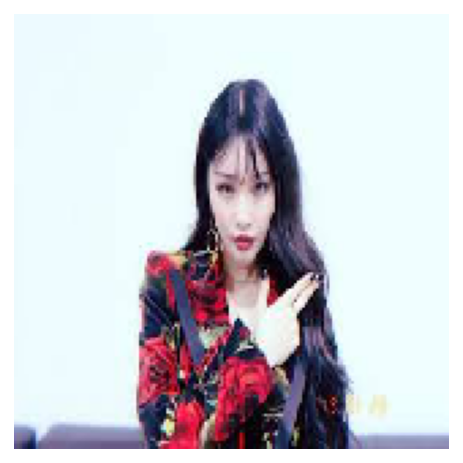

In [72]:
filename = 'human_rose.jpeg'
show_and_predict_image(img_dir_path, filename)

### 평가


tf_flowers 데이터 셋에 충분한 데이터가 없었기 때문에 사전학습모델인 VGG16를 바탕으로 모델을 만들었습니다. 그 중 직접 만든 모델과 사전학습 모델을 결합하는 부분에서 문제를 겪었습니다. 교육 자료를 복습하며 필요한 코드, 확인하고 싶은 코드, 필요없는 코드를 되짚어가며 모델 구조를 설계할 수 있었습니다.
모델 학습을 시키는 과정에서는 learning rate와 epoch 수를 증가시켜 약 90%의 높은 정확도를 구할 수 있었습니다.
모델 활용 과정에서는 형태가 정확한 이미지, 부정확한 이미지, 다른 이미지를 적용해보았습니다. tf_flowers 관련 문서를 찾아 라벨을 확인하며 함수를 만들었으나, 알고 보니 초반에 생성했던 이미지에서 확인할 수 있는 부분이어서 아쉬웠습니다.
모델을 학습시키는 중 주피터 노트북이 중단되는 상황이 종종 발생하였으나 이제 적응했습니다.
이미지 분류 모델에 대해 더 자세히 파악할 수 있는 시간이었습니다.